In [865]:
import numpy as np
import pandas as pd

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df != "******").all(axis=1)]
    
    col_map = {
        "długośćmm": "dlugoscmm",
        "szerokośćmm": "szerokoscmm",
        "kąt": "kat",
        "obwódmm": "obwodmm",
        "średnica_fereta_hmm": "srednica_fereta_hmm",
        "średn._martinamm": "sredn._martinamm",
        "średn._sitowamm": "sredn._sitowamm",
        "średnia_jaskrawość": "srednia_jaskrawosc"
    }

    if "długośćmm" in df.columns:
        df = df.rename(columns=col_map)
        if "szerokoscmm" in df.columns:
            df["szerokoscmm"] = df["szerokoscmm"].astype(np.float64)

    return df


In [866]:
import pandas as pd
import cv2
import numpy as np

def process_one_image(CSV_PATH_CORRECT = 'KolejnyTest/5M/x/report_5_x.csv',CSV_PATH_PREDICTED = 'KolejnyTest/5M/x/report_5_x.csv',IMAGE_PATH = f'KolejnyTest/5M/x/a.jpg'   ,OUTPUT_PATH = f'KolejnyTest/5M/x/a_marked.jpg'):
    # === CONFIG ===
            # Path to the original image
        # Where to save the output image

    # === LOAD IMAGE AND DATA ===
    img = cv2.imread(IMAGE_PATH)
    df_real = preprocess_df(pd.read_csv(CSV_PATH_CORRECT))
    df_predicted = preprocess_df(pd.read_csv(CSV_PATH_PREDICTED))

    height, width = img.shape[:2]

    # === DRAW OBJECTS ===
    for i, row in df_real.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            # angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 255, 0)  # Green
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        except Exception as e:
            print(e)

    
    for i, row in df_predicted.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            # angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 0, 255)  # Red
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        except Exception as e:
            print(e)

    # === SAVE RESULT ===
    cv2.imwrite(OUTPUT_PATH, img)
    print(f"Image saved to {OUTPUT_PATH}")

In [867]:
import os
import pandas as pd

def load_dfs_from_path(path="example"):

    combined_df = []

    for entry in os.scandir(path):  
        if entry.is_file() and entry.name.endswith(".csv"):
            df = pd.read_csv(entry.path)
            df = preprocess_df(df)
            combined_df.append(df)

    combined_df = pd.concat(combined_df, ignore_index=True)

    return combined_df

In [868]:
def get_individual_stats(df):
    df = preprocess_df(df)
    # Scaling
    df['dlugoscmm'] = df['dlugoscmm']/1.49
    df['szerokoscmm'] = df['szerokoscmm']/1.49
    df['powierzchniamm'] = df['powierzchniamm']/2.235

    # filtering the things that with high probability are not bacteria !TODO odkomentuj to po testach
    # df = df[df['dlugoscmm'] >= 0.2]
    # df = df[df['szerokoscmm'] <= 1.5]

    df['Pw'] = 3.14*(df['szerokoscmm']/2)**2+df['szerokoscmm']*(df['dlugoscmm']-df['szerokoscmm'])
    df['R'] = df['Pw'] / df['powierzchniamm']
    df['Dk'] = df['dlugoscmm']
    df['Sk'] = df['szerokoscmm']
    df['D/S'] = (df['Dk'] / df['Sk']).astype('float64')

    bacteria_types = []
    Dks = []
    Sks = []
    for idx,row  in df.iterrows():
        if row['dlugoscmm'] < 0.2 or row['szerokoscmm'] > 1.5:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            bacteria_types.append("Removed_dim")
        elif row['R'] > 1.2:
            Dks.append(row['szerokoscmm'])
            Sks.append(row['Pw']*0.8)
            bacteria_types.append("Krzywe")
        else:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            if round(row['D/S'],15) > 1.5:
                bacteria_types.append("Pałeczki")
            else:
                bacteria_types.append("Ziarniaki")
    df['bacteria_type'] = bacteria_types
    df['Dk'] = Dks
    df['Sk'] = Sks

    df['Ob'] =(3.14*(df['Sk']**3)/6)+(3.14*((df['Sk']**2)/4)*(df['Dk']-df['Sk']))
    # !TODO remove this
    # df = df[df['Ob']>0]
    df.loc[df['Ob'] <= 0, 'bacteria_type'] = "removed_ob"
    df['Ob'] = np.abs(df['Ob'])
    # -----------------

    df['bialko'] = 104.5 * (df['Ob']**0.59)
    df['wegiel'] = 0.86 * df['bialko']

    return df

In [869]:
def get_stats_for_bacteria_types(df,probe_volume_ml = 6):
    grouped = df.groupby("bacteria_type")
    result_count = grouped.size().reset_index(name="count")
    result = grouped["Ob"].mean().reset_index()

    result['bialko'] = 104.5 * (result['Ob']**0.59)
    result['wegiel'] = 0.86 * result['bialko']
    result['count_in_1_ml']=((result_count['count']*48097.39)/10)/(probe_volume_ml)
    result['biomasa'] =(((104.5*result['Ob']**0.59)*0.86)*result['count_in_1_ml'])/1000000

    return result

In [870]:
import numpy as np

def get_stats_for_for_ob_bins(df,probe_volume_ml = 6):
    bins = [0, 0.1, 0.2, 0.5, 1.0, float("inf")]
    labels = ["<=0.1", "0.1–0.2", "0.2–0.5", "0.5–1.0", ">1.0"]

    df["Ob_bucket"] = pd.cut(df["Ob"], bins=bins, labels=labels, right=True)

    grouped = df.groupby(["bacteria_type", "Ob_bucket"], observed=True)
    result_bio_stats = grouped.size().reset_index(name="count")

    total_bacteria_count = np.sum(result_bio_stats['count'])
    total_bacteria_count_1_ml = ((np.sum(result_bio_stats['count'])*48097.39)/10)/(probe_volume_ml)

    result_bio_stats['count_in_1_ml']=((result_bio_stats['count']*48097.39)/10)/(probe_volume_ml)
    result_bio_stats['bio_diversity'] =((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)*np.log10((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)

    return result_bio_stats

In [871]:
def get_speified_baceria_types_count(df):
    return df.groupby("bacteria_type").size().reset_index(name="count")

In [872]:
def get_shannon_index(result_bio_stats):
    return np.sum(result_bio_stats['bio_diversity'])*-1

In [873]:
import pandas as pd

def full_analyse(df,proube_volume_ml=6):
    df = preprocess_df(df)
    df = get_individual_stats(df)
    result = get_stats_for_bacteria_types(df,probe_volume_ml=proube_volume_ml)
    result_bio_stats = get_stats_for_for_ob_bins(df,probe_volume_ml=proube_volume_ml)
    specified_types_count_predicted =  get_speified_baceria_types_count(df)
    shannon_index = np.sum(result_bio_stats['bio_diversity'])*-1
    print(f"Shannon index: {shannon_index}")

    return specified_types_count_predicted,df

In [874]:
def compare_results(df_real, df_predicted,proube_volume_ml=6):
    print("real:")
    real_classif,real_df = full_analyse(df_real,proube_volume_ml=proube_volume_ml)
    print("predicted:")
    predicted_classif,predicted_df = full_analyse(df_predicted,proube_volume_ml=proube_volume_ml)
    real_classif = real_classif.add_suffix("_real")
    predicted_classif = predicted_classif.add_suffix("_predicted")
    merged = pd.merge(real_classif,predicted_classif,left_on="bacteria_type_real",right_on="bacteria_type_predicted", how="inner")
    merged = merged.drop(axis=1,columns=['bacteria_type_predicted'])
    merged = merged.rename(columns={"bacteria_type_real":"bacteria_type"})
    merged['error'] = merged['count_predicted']- merged['count_real']
    merged['relative_error'] = merged['error']/merged['count_real']
    return merged,real_df,predicted_df

In [875]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(real_df,predicted_df):
    y_true = real_df['bacteria_type']
    y_pred = predicted_df['bacteria_type']

    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true.unique())
    disp.plot(cmap="Blues", xticks_rotation=45)


In [876]:
df = load_dfs_from_path("agata_1_y_no_model")
predicted_classif = full_analyse(df,proube_volume_ml=6)
print(predicted_classif)

Shannon index: 0.9252722551885972
(  bacteria_type  count
0        Krzywe     43
1      Pałeczki    112
2   Removed_dim      1
3     Ziarniaki     37,      nr.   xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1   950.5  937.5   95.1  93.8        0.487696   1.275168     0.201342   
1      2  1116.5  910.5  111.7  91.1        0.299776   0.805369     0.335570   
2      3   760.5  845.5   76.0  84.6        0.241611   0.671141     0.402685   
3      4   445.5  830.5   44.6  83.1        0.152125   0.536913     0.536913   
4      5  1068.5  789.5  106.9  79.0        0.407159   1.073826     0.469799   
..   ...     ...    ...    ...   ...             ...        ...          ...   
188   11   303.5  334.5   30.4  33.5        0.675615   1.275168     0.536913   
189   12   188.5  327.5   18.9  32.8        0.214765   0.604027     0.536913   
190   13   276.5  325.5   27.7  32.6        0.384787   0.939597     0.536913   
191   14   640.5  266.5   64.0  26.7        0.178

In [877]:
df = load_dfs_from_path("agata_1_y_real")
real_classif = full_analyse(df,proube_volume_ml=6)
print(real_classif)

Shannon index: 0.9356544010592158
(  bacteria_type  count
0        Krzywe     14
1      Pałeczki    204
2   Removed_dim      2
3     Ziarniaki    129
4    removed_ob      2,      nr.  xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1    529    914   52.9  91.4        0.519016   0.997723     0.553437   
1      2   1096    910  109.6  91.0        0.420582   1.148808     0.402685   
2      3   1253    851  125.3  85.1        0.322148   0.830155     0.408239   
3      4   1150    811  115.0  81.1        0.326622   0.785550     0.408239   
4      5   1177    781  117.7  78.1        0.612975   1.332177     0.474568   
..   ...    ...    ...    ...   ...             ...        ...          ...   
346   15    108    467   10.8  46.7        0.715884   1.189265     0.750358   
347   16     21    398    2.1  39.8        0.675615   0.960928     0.816478   
348   17    635    394   63.5  39.4        0.532438   1.383592     0.488598   
349   18    888    115   88.8  11.5 

In [878]:
df_real = load_dfs_from_path("agata_1_y_real_correct_index")
df_predicted = load_dfs_from_path("no_model_agata_3")
# df_predicted = load_dfs_from_path("agata_1_y_no_model_2")
# df_predicted['powierzchniamm'] *= 1.15
# df_predicted['dlugoscmm'] *= 0.96
# df_predicted['szerokoscmm'] *= 0.9
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)

real:
Shannon index: 0.9714580520564581
predicted:
Shannon index: 0.9252722551885972
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe          10               43     33        3.300000
1      Pałeczki         124              112    -12       -0.096774
2   Removed_dim           2                1     -1       -0.500000
3     Ziarniaki          56               37    -19       -0.339286


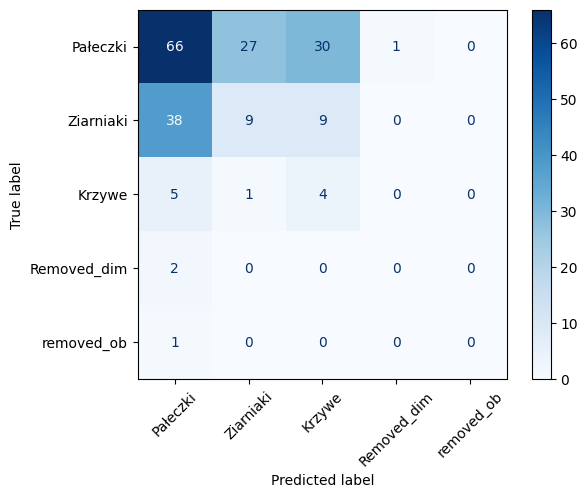

In [879]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [880]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.532708,0.889189,0.487470,0.378742
error_szerokoscmm,0.532708,1.000000,0.759222,0.704429,-0.422246
error_powierzchniamm,0.889189,0.759222,1.000000,0.438110,0.106420
error_R,0.487470,0.704429,0.438110,1.000000,-0.361838
error_D/S,0.378742,-0.422246,0.106420,-0.361838,1.000000


In [881]:
df_real = pd.read_csv("agata_1_y_real_correct_index/raport_a3.csv")
df_predicted = pd.read_csv("no_model_agata_3/a3_raport_no_model.csv")


In [882]:
df_real

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,długośćmm,szerokośćmm,kąt,obwódmm,...,średn._martinamm,średn._sitowamm,średnia_jaskrawość,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,2,974,882,97.4,88.2,1.21,1.476482,0.943398,61.70,3.768320,...,1.1,1.044031,225.6,105.9,156.2,166.3,141.6,30,100.0,12288.0
1,3,146,827,14.6,82.7,0.62,1.000000,0.583095,36.87,2.627664,...,0.7,0.781025,221.2,115.4,166.6,184.4,152.6,30,100.0,12288.0
2,4,1223,766,122.3,76.6,1.02,1.392839,0.824621,68.96,3.631773,...,0.9,0.800000,226.5,104.8,158.8,171.7,143.4,30,100.0,12288.0
3,5,329,720,32.9,72.0,2.21,2.220360,1.140175,35.84,5.805614,...,1.8,1.272792,226.3,124.4,164.9,187.0,154.6,30,100.0,12288.0
4,6,944,699,94.4,69.9,0.69,1.170470,0.728011,19.98,2.987016,...,1.2,0.700000,212.4,118.6,161.4,168.6,148.8,30,100.0,12288.0
5,7,719,675,71.9,67.5,1.10,1.360147,0.860233,53.97,3.559765,...,1.2,0.989949,231.9,114.2,163.9,176.7,149.8,30,100.0,12288.0
6,8,206,621,20.6,62.1,2.11,2.256103,1.104536,77.20,5.896594,...,0.9,1.100000,229.4,112.4,158.5,182.5,146.7,30,100.0,12288.0
7,9,852,616,85.2,61.6,0.35,0.670820,0.538516,26.57,1.678353,...,0.6,0.500000,207.9,118.9,160.6,151.3,146.4,30,100.0,12288.0
8,10,1215,588,121.5,58.8,0.73,1.640122,0.500000,37.57,3.934074,...,1.0,0.721110,221.2,97.9,143.0,151.4,129.7,30,100.0,12288.0
9,11,409,549,40.9,54.9,0.53,0.921954,0.640312,130.60,2.497607,...,0.9,0.700000,219.6,132.6,182.4,191.1,167.7,30,100.0,12288.0


In [883]:
df_predicted

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,sredn._martinamm,sredn._sitowamm,srednia_jaskrawosc,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,1,973.5,882.5,97.4,88.2,0.93,1.6,0.9,18.13,4.252691,...,1.6,1.085240,144.9,109.5,158.6,167.4,144.9,1,10.8,10.2
1,2,145.5,827.5,14.6,82.8,0.54,1.1,0.6,28.26,2.814214,...,1.1,0.829186,145.3,112.7,157.5,168.5,145.4,1,8.6,7.8
2,3,1222.5,766.5,122.2,76.7,1.04,1.5,0.4,6.63,4.097056,...,1.5,1.150725,128.1,93.3,140.6,155.3,128.1,1,12.9,9.6
3,4,328.5,720.5,32.9,72.0,1.37,2.0,0.8,52.31,4.887006,...,2.0,1.318322,186.5,155.7,197.4,211.0,186.5,1,11.6,13.7
4,5,943.5,699.5,94.4,70.0,0.60,1.2,0.7,81.35,3.155635,...,1.2,0.870389,139.2,111.5,149.6,158.2,139.2,1,8.8,8.4
5,6,718.5,675.5,71.9,67.5,0.93,1.5,0.8,31.95,3.862742,...,1.5,1.088169,147.0,113.2,159.5,171.1,147.0,1,10.8,10.2
6,7,205.5,621.5,20.6,62.2,1.48,2.3,0.9,7.64,5.994112,...,2.3,1.372732,157.8,123.1,170.1,185.6,157.8,1,13.1,13.3
7,8,851.5,616.5,85.2,61.7,0.53,0.9,0.8,125.56,3.062742,...,0.9,0.821472,112.8,91.8,122.3,119.3,112.8,1,9.8,6.8
8,9,1214.5,588.5,121.5,58.9,0.97,2.1,0.6,51.60,5.169848,...,2.1,1.108457,104.5,78.6,113.8,124.4,104.5,1,11.6,10.2
9,10,408.5,549.5,40.9,55.0,0.53,1.0,0.5,165.63,2.731371,...,1.0,0.821472,142.7,112.0,154.2,163.8,142.7,1,8.4,7.8


In [884]:
# df_predicted['powierzchniamm'] *= 1.1
# df_predicted['dlugoscmm'] *= 0.96
# df_predicted['szerokoscmm'] *= 0.96

In [885]:

# df_predicted['szerokoscmm'] = df_real['szerokośćmm']
# df_predicted['dlugoscmm'] = df_real['długośćmm']
# df_predicted['powierzchniamm'] = df_real['powierzchniamm']

In [886]:
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)
mean_abs_erron = np.mean(np.abs(compared['relative_error']))

real:
Shannon index: 0.7325783444855738
predicted:
Shannon index: 0.7079234599492025
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe           1                6      5        5.000000
1      Pałeczki          20               16     -4       -0.200000
2     Ziarniaki           3                2     -1       -0.333333


In [887]:
real_df['bacteria_type']

0      Pałeczki
1      Pałeczki
2      Pałeczki
3      Pałeczki
4      Pałeczki
5      Pałeczki
6      Pałeczki
7     Ziarniaki
8      Pałeczki
9     Ziarniaki
10     Pałeczki
11     Pałeczki
12    Ziarniaki
13     Pałeczki
14     Pałeczki
15       Krzywe
16     Pałeczki
17     Pałeczki
18     Pałeczki
19     Pałeczki
20     Pałeczki
21     Pałeczki
22     Pałeczki
23     Pałeczki
Name: bacteria_type, dtype: object

In [888]:
predicted_df['bacteria_type']

0        Krzywe
1      Pałeczki
2      Pałeczki
3      Pałeczki
4        Krzywe
5      Pałeczki
6        Krzywe
7     Ziarniaki
8        Krzywe
9      Pałeczki
10     Pałeczki
11     Pałeczki
12     Pałeczki
13     Pałeczki
14     Pałeczki
15     Pałeczki
16     Pałeczki
17     Pałeczki
18       Krzywe
19     Pałeczki
20       Krzywe
21     Pałeczki
22    Ziarniaki
23     Pałeczki
Name: bacteria_type, dtype: object

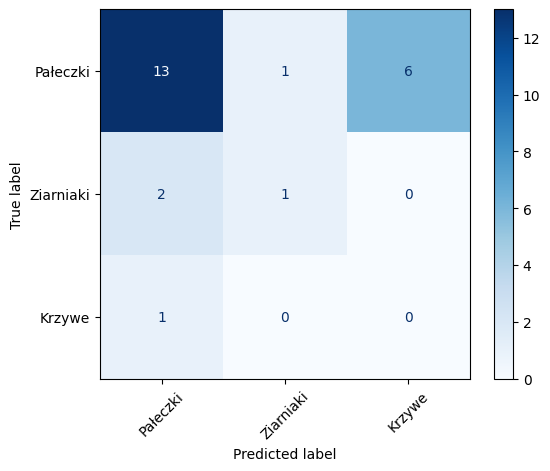

In [889]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [890]:
real_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']]

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
0,2,0.541387,0.990928,0.633153,0.541219,0.999690,1.565068
1,3,0.277405,0.671141,0.391339,0.229717,0.828094,1.714986
2,4,0.456376,0.934791,0.553437,0.451495,0.989305,1.689065
3,5,0.988814,1.490175,0.765218,1.014414,1.025889,1.947385
4,6,0.308725,0.785550,0.488598,0.332492,1.076984,1.607764
5,7,0.492170,0.912850,0.577337,0.455359,0.925207,1.581139
6,8,0.944072,1.514163,0.741299,1.004300,1.063797,2.042580
7,9,0.156600,0.450215,0.361420,0.134633,0.859725,1.245682
8,10,0.326622,1.100753,0.335570,0.345170,1.056786,3.280244
9,11,0.237136,0.618761,0.429740,0.226201,0.953885,1.439851


In [891]:
predicted_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']]

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
0,1,0.416107,1.073826,0.604027,0.570177,1.370264,1.777778
1,2,0.241611,0.738255,0.402685,0.262421,1.086130,1.833333
2,3,0.465324,1.006711,0.268456,0.254763,0.547496,3.750000
3,4,0.612975,1.342282,0.536913,0.658709,1.074609,2.500000
4,5,0.268456,0.805369,0.469799,0.330909,1.232634,1.714286
5,6,0.416107,1.006711,0.536913,0.478537,1.150032,1.875000
6,7,0.662192,1.543624,0.604027,0.853948,1.289577,2.555556
7,8,0.237136,0.604027,0.536913,0.262331,1.106243,1.125000
8,9,0.434004,1.409396,0.402685,0.532679,1.227358,3.500000
9,10,0.237136,0.671141,0.335570,0.201004,0.847632,2.000000


In [892]:
real_df['powierzchniamm']-predicted_df['powierzchniamm']

0     0.125280
1     0.035794
2    -0.008949
3     0.375839
4     0.040268
5     0.076063
6     0.281879
7    -0.080537
8    -0.107383
9     0.000000
10   -0.022371
11   -0.053691
12    0.326622
13   -0.008949
14   -0.129754
15   -0.058166
16    0.044743
17    0.143177
18   -0.022371
19   -0.049217
20   -0.093960
21    0.022371
22   -0.067114
23   -0.031320
Name: powierzchniamm, dtype: float64

In [893]:
real_df['dlugoscmm']-predicted_df['dlugoscmm']

0    -0.082898
1    -0.067114
2    -0.071920
3     0.147893
4    -0.019819
5    -0.093861
6    -0.029461
7    -0.153812
8    -0.308643
9    -0.052380
10   -0.131437
11   -0.227815
12    0.083789
13   -0.092901
14   -0.198551
15   -0.043117
16    0.062308
17   -0.040532
18   -0.093888
19   -0.148437
20   -0.201342
21    0.002792
22   -0.128674
23   -0.099049
Name: dlugoscmm, dtype: float64

In [894]:
real_df['szerokoscmm']-predicted_df['szerokoscmm']

0     0.029126
1    -0.011346
2     0.284981
3     0.228306
4     0.018799
5     0.040425
6     0.137273
7    -0.175492
8    -0.067114
9     0.094169
10    0.134228
11   -0.134228
12    0.229678
13   -0.058852
14   -0.227815
15    0.676714
16   -0.048315
17    0.346680
18   -0.107173
19   -0.030604
20   -0.347085
21    0.362626
22   -0.268456
23    0.214633
Name: szerokoscmm, dtype: float64

In [895]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.540915,0.781162,0.353653,-0.291513
error_szerokoscmm,0.540915,1.000000,0.397484,0.909850,-0.766451
error_powierzchniamm,0.781162,0.397484,1.000000,0.048387,-0.015061
error_R,0.353653,0.909850,0.048387,1.000000,-0.864009
error_D/S,-0.291513,-0.766451,-0.015061,-0.864009,1.000000


In [896]:
for i in range(1,11):
    try:
        process_one_image(IMAGE_PATH=f'images_y/a{i}.jpg',CSV_PATH_CORRECT=f'agata_1_y_real_correct_index/raport_a{i}.csv',CSV_PATH_PREDICTED=f'no_model_agata_3/a{i}_raport_no_model.csv',OUTPUT_PATH=f'no_model_agata_3/a{i}_elipses_compare.jpg')
    except:
        continue

Image saved to no_model_agata_3/a1_elipses_compare.jpg
Image saved to no_model_agata_3/a3_elipses_compare.jpg
Image saved to no_model_agata_3/a4_elipses_compare.jpg
Image saved to no_model_agata_3/a5_elipses_compare.jpg
Image saved to no_model_agata_3/a6_elipses_compare.jpg
Image saved to no_model_agata_3/a7_elipses_compare.jpg
Image saved to no_model_agata_3/a8_elipses_compare.jpg
Image saved to no_model_agata_3/a9_elipses_compare.jpg
Image saved to no_model_agata_3/a10_elipses_compare.jpg
